In [1]:
# load matplotlib inline mode
%matplotlib inline

# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
import matplotlib as matplotlib
from scipy import stats
from scipy.linalg import block_diag
import seaborn as sns

In [2]:
def _calc_D(s):
    # calc all the differences
    s0__1 = s[1:-1] - s[:-2]
    s1_0 = s[2:] - s[1:-1]
    s1__1 = s[2:] - s[:-2]

    # calc the -1, 0, and 1 diagonals
    A = -((s1_0/s1__1)/s0__1)
    B = -((s0__1/s1__1)/s1_0) + (s1_0/s1__1)/s0__1
    C = (s0__1/s1__1)/s1_0

    # create the matrix
    D = np.zeros((len(s), len(s)))
    D.flat[len(s):-2:len(s)+1] = A
    D.flat[len(s)+1:-1:len(s)+1] = B
    D.flat[len(s)+2::len(s)+1] = C
    
    return D.T
def my_mat_power(x, n, x0=None):
    if x0 is None:
        x0 = x
    if n == 1:
        return x
    elif n == 2:
        return np.dot(x, x0)
    elif n > 2:
        return my_mat_power(np.dot(x, x0), n-1, x0=x0)
    else:
        raise ValueError("Only positive n are allowed.")
    
def _calc_invL2(s, k):
    # calc finite differentiation matrix from s
    D = np.float128(_calc_D(np.float128(s)))
    
    # Post inverse Laplace linear operator
    #invL = (((-1.) ** k) / factorial(k)) * \
    #        np.dot(np.linalg.matrix_power(D, k), np.diag(s ** (k+1)))[:, k:-k]
    invL = (((-1.) ** k) * \
            my_mat_power(D, k) * np.exp(np.log(s)*(k+1) - 
                                        np.log(np.arange(2,k+1)).sum()))[:, k:-k]
    

    # return as ndarray
    return np.float64(invL)

In [3]:
class iSITH():
    def __init__(self, tau_min=.1, tau_max=20., k=8, ntau=50, dt=0.01, g=0.0):
        self.k = k
        self.tau_min = tau_min
        self.tau_max = tau_max
        self.ntau = ntau
        self.dt = dt
        self.g = g

        self.c = (self.tau_max/self.tau_min)**(1./(self.ntau-1))-1
        self.tau_star = self.tau_min * (1 + self.c)**np.arange(-self.k, self.ntau + self.k)
        self.s = (1/self.tau_star)
        self.invL = _calc_invL2(self.s, k)

In [52]:
#Variables for generation of s values:
k = 8
ntau = 30
dt = 0.01
tau_min = 0.1
tau_max = 10
rho = 0.3

In [53]:
#generate s, and subsequently, tau_star
Sith = iSITH(tau_min=tau_min,tau_max=tau_max,ntau=ntau,k=k)
S = np.outer([1,1],Sith.s)
nt = len(Sith.s)

## Pair-wise association between X and Y, two different unit vector representing different states of f<sub>t</sub> with X presented at t=0 and Y presented at t=tau_0:

In [54]:
X = np.array([1,0])
Y = np.array([0,1])
#Arbitrary value of tau_0, only that it is between tau_min and tau_max:
tau_0 = 4

### At t = 0, X is presented. F<sup>-</sup><sub>t</sub>(s), the Laplace transform of f<sub>t</sub>, is then equal to the Laplace transform of a delta function:

In [55]:
#Initialize F-minus to all zeros:
F_m = np.zeros([nt,2])
#Equation 8 from the document:
F_m = np.exp(-S*0).T*F_m + (np.exp(S*0).T * X)
#Input 1's into F-minus at X's position, throughout all s.
#print(F_m)

In [56]:
#Initialize M based on the number of s values and the number of symbols:
M = np.zeros([nt,2,2])
#Equation 9, where all values from-X in M are decayed by rho:
M[:,0,1] = rho * M[:,0,1]

### Allow time to progress away from t=0, up until Y is presented at tau_0. At this point, matrix M gains non-zero values.

In [57]:
steps_minus = np.arange(dt,tau_0+dt, dt)
#We record the values of F_m for graphing:
F_m_record = F_m[:,0]
for t in steps_minus:
    #equation 3:
    F_m = F_m *  np.exp(-S * dt).T
    F_m_record = np.vstack([F_m_record,F_m[:,0]])

#Y is presented, equation 8 again:
F_m = np.exp(-S*0).T*F_m + (np.exp(S*0).T * Y)

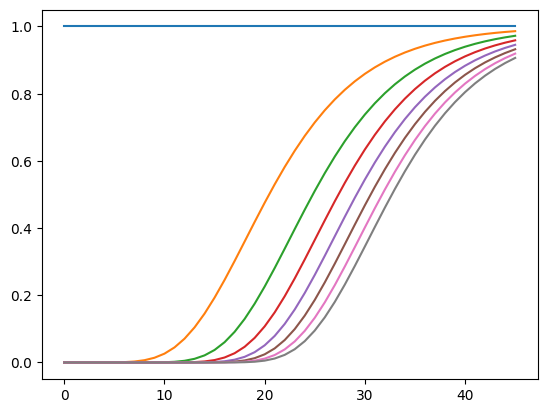

In [58]:
#Plotting any row of F_m_record will give us the value of F-minus, as in bottom of Figure 3:
for i in np.arange(0,392,50): 
    plt.plot(F_m_record[i,:])

In [59]:
#Equation 10, where all values to-Y in M are equal to F-minus decayed by (1-rho):
M[:,0,1] = M[:,0,1] + (1-rho)* np.dot(F_m,X)

### From here, once X is presented again, F<sup>+</sup><sub>t</sub> gains non-zero values due to the stored values in M:

In [60]:
#Initialize F-plus:
F_p = np.zeros([nt, 2])

#Select some time frame for predictions to come about
steps_plus = np.arange(dt,tau_0+2+dt, dt)
F_p_record = F_p[:,1]

#The second-to-last term of 15, which equals 0 at all times but the last:
F_p_smax = np.zeros([nt, 2])

for t in steps_plus:
    #When X is presented at a certain time, there is non-zero input into F_plus:
    if t == 1.0:
        F_p_input = np.dot(X.T, M[:])
    else:
        F_p_input = np.zeros([nt, 2])       
    F_p = np.exp(S*dt).T * F_p - F_p_smax + F_p_input
    F_p_record = np.vstack([F_p_record,F_p[:,1]])
    #determine if F_p_smax has reached sufficient peak and take out F_p_smax
    if F_p[0,1] > F_p[1,1]:
        F_p = np.exp(-S*dt).T * F_p
        F_p = F_p - F_p

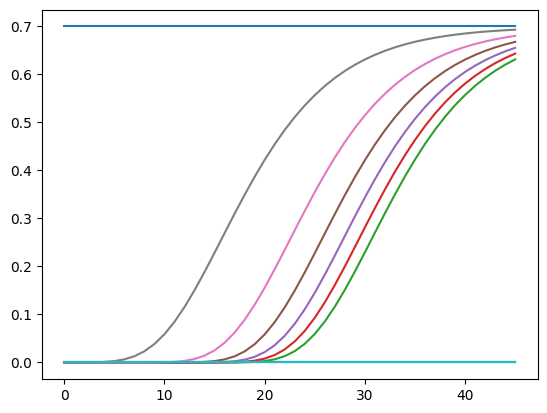

In [61]:
for i in np.linspace(0,len(steps_plus)-1,10): 
    plt.plot(F_p_record[round(i),:])
    
#Plot the moment predictions reach their peak at the same time:
plt.plot(F_p_record[-101,:])

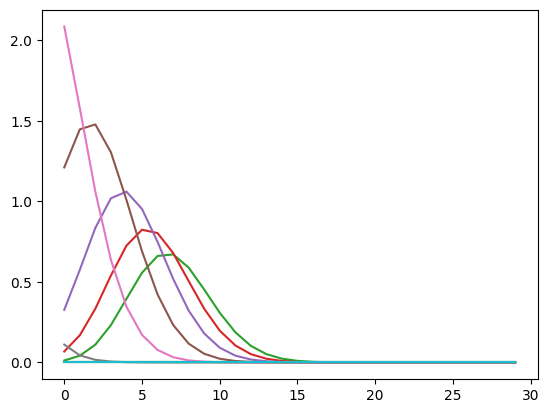

In [62]:
inverseF_p = np.dot(F_p_record, Sith.invL)
for i in np.linspace(0,len(steps_plus)-1,10): 
    plt.plot(inverseF_p[round(i),:])

In [70]:
gamma = 0.6
V_t = inverseF_p.sum(axis=1)
V_plus_one = np.append(gamma*V_t[1:], 0)

#The "Reward", aka presentation of Y, is expected at 
#the same point which predicitions reset
reward = np.zeros(len(V_t))
reward[-101] = 1

#Prediction Error:
prediction_error = reward + V_plus_one - V_t 

Text(0.5, 0, 'Time (ms)')

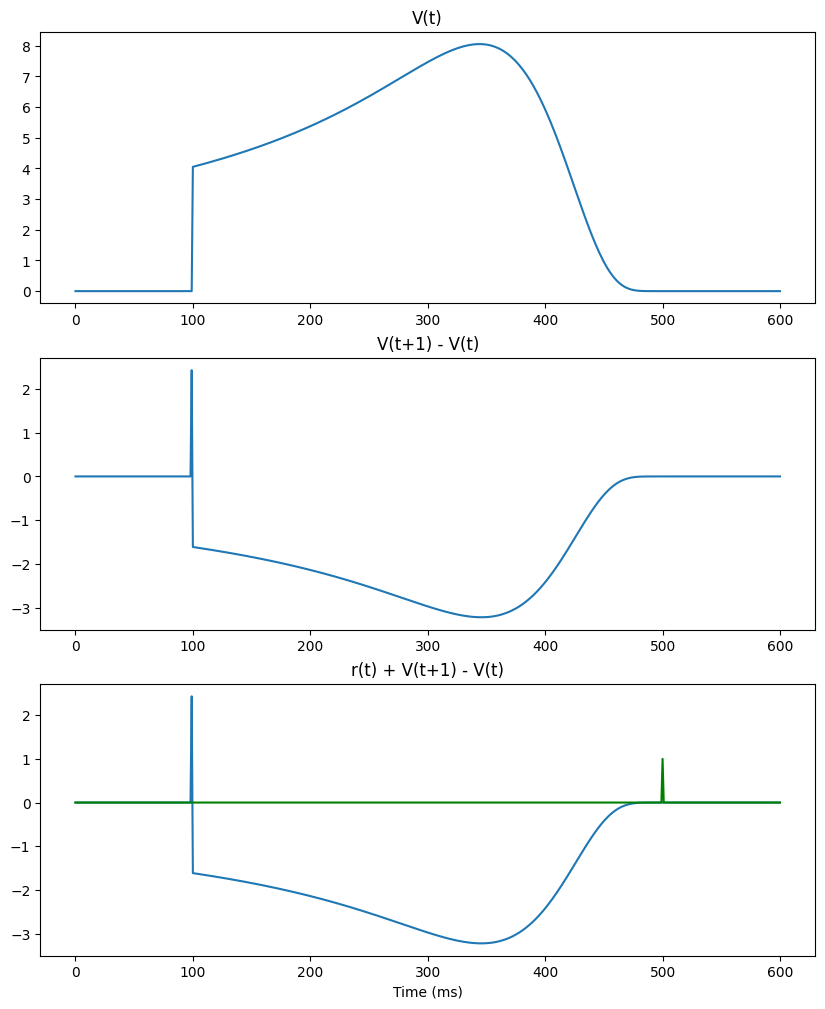

In [73]:
fig, ax = plt.subplots(3,1, figsize = (10,12))
ax[0].plot(V_t)
ax[1].plot(V_plus_one - V_t )
ax[2].plot(V_plus_one - V_t, label='prediction error')
ax[2].plot(reward, color='green', label='reward')

ax[0].set_title("V(t)")
ax[1].set_title("V(t+1) - V(t)")
ax[2].set_title("r(t) + V(t+1) - V(t)")

ax[2].set_xlabel('Time (ms)')